[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-3/dynamic-breakpoints.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239526-lesson-4-dynamic-breakpoints)

# Dynamic breakpoints 

## Review

human-in-the-loopの理由について議論しました。

(1)  `承認(Approval)` - エージェントを中断し、状態をユーザーに表示し、ユーザーがアクションを承認できるようにします

(2) `デバッグ(Debugging)` - グラフを巻き戻して問題を再現したり回避したりすることができます

(3) `編集(Editing)` - 状態を修正することができます 

特定のステップでグラフを停止させる一般的な方法としてブレークポイントを取り上げましたが、これにより「承認」のようなユースケースが可能になります。

また、グラフの状態を編集する方法と、人間のフィードバックの導入についても説明しました。 

## Goals

ブレークポイントは、グラフのコンパイル中に開発者が特定のノードに設定します。 

しかし、グラフを**動的に中断**させることが役立つ場合もあります!

これは内部ブレークポイントであり、[`NodeInterrupt`を使用して実現できます](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/dynamic_breakpoints/#run-the-graph-with-dynamic-interrupt)。

これにはいくつかの利点があります。

(1) 条件付きで実行できます(開発者が定義したロジックに基づくノード内から)。

(2) (`NodeInterrupt` に任意の値を渡すことで)ユーザーに中断理由を伝えることができます。

入力の長さに基づいて `NodeInterrupt` がスローされるグラフを作成してみましょう。


In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk

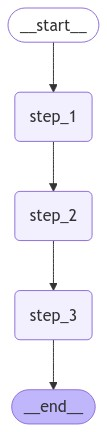

In [1]:
from IPython.display import Image, display

from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver
from langgraph.errors import NodeInterrupt
from langgraph.graph import START, END, StateGraph


class State(TypedDict):
    input: str


def step_1(state: State) -> State:
    print("---Step 1---")
    return state


def step_2(state: State) -> State:
    # inputの長さが5文字を超過する場合は、オプションでNodeInterruptを発生させます。
    if len(state["input"]) > 5:
        raise NodeInterrupt(f"Received input that is longer than 5 characters: {state['input']}")

    print("---Step 2---")
    return state


def step_3(state: State) -> State:
    print("---Step 3---")
    return state


builder = StateGraph(State)
builder.add_node("step_1", step_1)
builder.add_node("step_2", step_2)
builder.add_node("step_3", step_3)
builder.add_edge(START, "step_1")
builder.add_edge("step_1", "step_2")
builder.add_edge("step_2", "step_3")
builder.add_edge("step_3", END)

# Set up memory
memory = MemorySaver()

# Compile the graph with memory
graph = builder.compile(checkpointer=memory)

# View
display(Image(graph.get_graph().draw_mermaid_png()))

5文字より長いinputでグラフを実行してみましょう。

In [2]:
initial_input = {"input": "hello world"}  # len("hello world") > 5 を満たす
thread_config = {"configurable": {"thread_id": "1"}}

# 最初のinterruptionまでグラフを実行する
for event in graph.stream(initial_input, thread_config, stream_mode="values"):
    print(event)

{'input': 'hello world'}
---Step 1---
{'input': 'hello world'}


If we inspect the graph state at this point, we the node set to execute next (`step_2`).

この時点でグラフの状態を検査すると、次に実行するノードセットは(`step2`)



In [3]:
state = graph.get_state(thread_config)
print(state.next)

('step_2',)


`Interrupt` が状態に記録されていることがわかります。

In [4]:
print(state.tasks)

(PregelTask(id='44ab6a36-c87b-ad1b-4fc9-444ccbb0baf9', name='step_2', path=('__pregel_pull', 'step_2'), error=None, interrupts=(Interrupt(value='Received input that is longer than 5 characters: hello world', when='during'),), state=None),)


breakpointからグラフを再開できます

しかし、これは同じノードを再実行するだけです!

状態が変更されない限り、私たちはここで立ち往生することになります。




In [6]:
for event in graph.stream(None, thread_config, stream_mode="values"):
    print(event)

{'input': 'hello world'}


In [7]:
state = graph.get_state(thread_config)
print(state.next)

('step_2',)


ひとつ下のセルの操作で、状態を更新できます。

In [8]:
graph.update_state(
    thread_config,
    {"input": "hi"},  # len("hi") > 5 を満たさない
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef846f0-1d72-6957-8002-5f7132ffd9bd'}}

In [9]:
# グラフの再実行。停止条件に合致しないので、最後まで実行される
for event in graph.stream(None, thread_config, stream_mode="values"):
    print(event)

{'input': 'hi'}
---Step 2---
{'input': 'hi'}
---Step 3---
{'input': 'hi'}


### LangGraph API との使用

--

**⚠️ 免責事項**

*Studio を実行するには現在 Mac が必要です。Mac を使用していない場合は、この手順をスキップしてください。*

*また、このノートブックを CoLab で実行している場合も、この手順をスキップしてください。*

--

`module-3/studio/dynamic_breakpoints.py` を使用して、上記のグラフを Studio で実行できます。

![Screenshot 2024-08-27 at 2.02.20 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbaedf43c3d4df239c589e_dynamic-breakpoints1.png)


In [ ]:
from IPython import get_ipython
import platform

if "google.colab" in str(get_ipython()) or platform.system() != "Darwin":
    raise Exception("Unfortunately LangGraph Studio is currently not supported on Google Colab or requires a Mac")

We connect to it via the SDK.

In [11]:
from langgraph_sdk import get_client

# Replace this with the URL of your own deployed graph
URL = "http://localhost:62575"
client = get_client(url=URL)

# Search all hosted graphs
assistants = await client.assistants.search()

In [12]:
thread = await client.threads.create()
input_dict = {"input": "hello world"}

async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="dynamic_breakpoints",
    input=input_dict,
    stream_mode="values",
):
    print(f"Receiving new event of type: {chunk.event}...")
    print(chunk.data)
    print("\n\n")

Receiving new event of type: metadata...
{'run_id': '1ef6a43a-1b04-64d0-9a79-1caff72c8a89'}



Receiving new event of type: values...
{'input': 'hello world'}



Receiving new event of type: values...
{'input': 'hello world'}





In [13]:
current_state = await client.threads.get_state(thread["thread_id"])

In [14]:
current_state["next"]

['step_2']

In [15]:
await client.threads.update_state(thread["thread_id"], {"input": "hi!"})

{'configurable': {'thread_id': 'ea8c2912-987e-49d9-b890-6e81d46065f9',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef6a43a-64b2-6e85-8002-3cf4f2873968'},
 'checkpoint_id': '1ef6a43a-64b2-6e85-8002-3cf4f2873968'}

In [23]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="dynamic_breakpoints",
    input=None,
    stream_mode="values",
):
    print(f"Receiving new event of type: {chunk.event}...")
    print(chunk.data)
    print("\n\n")

Receiving new event of type: metadata...
{'run_id': '1ef64c33-fb34-6eaf-8b59-1d85c5b8acc9'}



Receiving new event of type: values...
{'input': 'hi!'}



Receiving new event of type: values...
{'input': 'hi!'}





In [16]:
current_state = await client.threads.get_state(thread["thread_id"])
current_state

{'values': {'input': 'hi!'},
 'next': ['step_2'],
 'tasks': [{'id': '858e41b2-6501-585c-9bca-55c1e729ef91',
   'name': 'step_2',
   'error': None,
   'interrupts': [],
   'state': None}],
 'metadata': {'step': 2,
  'source': 'update',
  'writes': {'step_1': {'input': 'hi!'}},
  'parents': {},
  'graph_id': 'dynamic_breakpoints'},
 'created_at': '2024-09-03T22:27:05.707260+00:00',
 'checkpoint_id': '1ef6a43a-64b2-6e85-8002-3cf4f2873968',
 'parent_checkpoint_id': '1ef6a43a-1cb8-6c3d-8001-7b11d0d34f00'}